In [18]:
# Re-extract data with ALL orderbook levels (all 20 levels)
import sys
import os
import pandas as pd
import json

# Add parent directory to path for imports
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from hyperliquid_snapshots.decompress import decompress_lz4_file

hours = [0, 1, 2, 3]
all_rows = []

for hour in hours:
    lz4_path = os.path.join('..', 'data', 'market_data', '20250610', str(hour), 'l2Book', 'HYPE.lz4')
    json_path = lz4_path.replace('.lz4', '')
    
    # Decompress if not already decompressed
    if not os.path.exists(json_path):
        decompress_lz4_file(lz4_path, remove_src=False)
    
    # Parse JSONL
    with open(json_path, 'r') as f:
        for line in f:
            if line.strip():
                record = json.loads(line)
                raw_data = record.get('raw', {}).get('data', {})
                time = raw_data.get('time', None)
                coin = raw_data.get('coin', None)
                levels = raw_data.get('levels', [])
                
                if len(levels) >= 2:
                    bids = levels[0]
                    asks = levels[1]
                    
                    # Get best bid and ask (for mid price and spread)
                    best_bid_px = float(bids[0]['px']) if bids else None
                    best_bid_sz = float(bids[0]['sz']) if bids else None
                    best_ask_px = float(asks[0]['px']) if asks else None
                    best_ask_sz = float(asks[0]['sz']) if asks else None
                    
                    # Calculate mid price and spread
                    mid_price = (best_bid_px + best_ask_px) / 2 if best_bid_px and best_ask_px else None
                    spread = best_ask_px - best_bid_px if best_bid_px and best_ask_px else None
                    
                    # Sum ALL bid and ask sizes across all levels
                    total_bid_size = sum(float(bid['sz']) for bid in bids)
                    total_ask_size = sum(float(ask['sz']) for ask in asks)
                    
                    all_rows.append({
                        'time': time,
                        'coin': coin,
                        'hour': hour,
                        'best_bid_px': best_bid_px,
                        'best_bid_sz': best_bid_sz,
                        'best_ask_px': best_ask_px,
                        'best_ask_sz': best_ask_sz,
                        'mid_price': mid_price,
                        'spread': spread,
                        'total_bid_size': total_bid_size,
                        'total_ask_size': total_ask_size
                    })

# Create DataFrame
df = pd.DataFrame(all_rows)
df['time'] = pd.to_datetime(df['time'], unit='ms')
df = df.sort_values('time').reset_index(drop=True)

print(f"✓ Re-extracted {len(df)} rows with ALL orderbook levels")
print(f"\nNew columns added:")
print(f"  - total_bid_size: Sum of all bid sizes across all 20 levels")
print(f"  - total_ask_size: Sum of all ask sizes across all 20 levels")
print(f"\nTotal size statistics:")
print(df[['total_bid_size', 'total_ask_size']].describe())
df.head(10)

✓ Re-extracted 26337 rows with ALL orderbook levels

New columns added:
  - total_bid_size: Sum of all bid sizes across all 20 levels
  - total_ask_size: Sum of all ask sizes across all 20 levels

Total size statistics:
       total_bid_size  total_ask_size
count    26337.000000    26337.000000
mean      2096.384237     2587.298989
std       2119.494404     1864.084803
min         24.980000       27.190000
25%       1058.450000     1529.430000
50%       1520.020000     2093.650000
75%       2366.030000     2944.170000
max      19499.660000    25205.490000


,time,coin,hour,best_bid_px,best_bid_sz,best_ask_px,best_ask_sz,mid_price,spread,total_bid_size,total_ask_size
0,2025-06-10 00:00:08.551,HYPE,0,38.845,11.57,38.847,25.00,38.8460,0.002,1537.51,3422.54
1,2025-06-10 00:00:08.605,HYPE,0,38.845,11.57,38.847,25.00,38.8460,0.002,1573.96,3425.67
2,2025-06-10 00:00:09.167,HYPE,0,38.835,1.04,38.846,23.81,38.8405,0.011,2411.13,3504.69
3,2025-06-10 00:00:09.686,HYPE,0,38.845,2.60,38.846,25.00,38.8455,0.001,1819.59,3703.49
4,2025-06-10 00:00:10.200,HYPE,0,38.838,29.97,38.841,25.00,38.8395,0.003,2117.69,3814.25
5,2025-06-10 00:00:10.752,HYPE,0,38.841,15.42,38.842,39.67,38.8415,0.001,1882.03,3361.98
6,2025-06-10 00:00:11.291,HYPE,0,38.852,641.21,38.853,16.35,38.8525,0.001,2656.88,3964.17
7,2025-06-10 00:00:11.809,HYPE,0,38.852,644.94,38.853,12.87,38.8525,0.001,1736.54,3413.52
8,2025-06-10 00:00:12.359,HYPE,0,38.852,647.54,38.856,12.29,38.8540,0.004,2157.89,4157.73
9,2025-06-10 00:00:12.919,HYPE,0,38.857,2.57,38.858,13.25,38.8575,0.001,1314.27,3679.15


In [19]:
# Get start and end time of the dataset
print("=" * 80)
print("DATASET TIME RANGE")
print("=" * 80)

start_time = df['time'].min()
end_time = df['time'].max()
duration = end_time - start_time

print(f"\nStart time: {start_time}")
print(f"End time:   {end_time}")
print(f"Duration:   {duration}")
print(f"Duration:   {duration.total_seconds() / 3600:.2f} hours")
print(f"\nTotal rows: {len(df):,}")
print(f"Average time between snapshots: {duration.total_seconds() / len(df):.3f} seconds")

print("\n" + "=" * 80)

DATASET TIME RANGE

Start time: 2025-06-10 00:00:08.551000
End time:   2025-06-10 03:59:59
Duration:   0 days 03:59:50.449000
Duration:   4.00 hours

Total rows: 26,337
Average time between snapshots: 0.546 seconds



In [20]:
# Summary statistics of the DataFrame
print("=" * 60)
print("DATAFRAME SUMMARY")
print("=" * 60)
print(f"\nShape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Time range: {df['time'].min()} to {df['time'].max()}")
print(f"Duration: {df['time'].max() - df['time'].min()}")
print(f"\nCoins: {df['coin'].unique()}")
print(f"Hours covered: {sorted(df['hour'].unique())}")

print("\n" + "=" * 60)
print("NUMERICAL STATISTICS")
print("=" * 60)
print(df[['best_bid_px', 'best_ask_px', 'mid_price', 'spread', 
         'best_bid_sz', 'best_ask_sz']].describe())

print("\n" + "=" * 60)
print("MISSING VALUES")
print("=" * 60)
print(df.isnull().sum())

print("\n" + "=" * 60)
print("SAMPLE DATA")
print("=" * 60)
df.head(5)

DATAFRAME SUMMARY

Shape: 26,337 rows × 11 columns
Time range: 2025-06-10 00:00:08.551000 to 2025-06-10 03:59:59
Duration: 0 days 03:59:50.449000

Coins: ['HYPE']
Hours covered: [0, 1, 2, 3]

NUMERICAL STATISTICS
        best_bid_px   best_ask_px     mid_price        spread   best_bid_sz  \
count  26337.000000  26337.000000  26337.000000  26337.000000  26337.000000   
mean      38.976469     38.978679     38.977574      0.002210    165.053807   
std        0.204818      0.204491      0.204645      0.004002    604.626609   
min       38.457000     38.458000     38.457500      0.001000      0.010000   
25%       38.826000     38.830000     38.828500      0.001000     12.980000   
50%       39.026000     39.027000     39.026500      0.001000     32.400000   
75%       39.123000     39.125000     39.124500      0.001000     99.710000   
max       39.414000     39.415000     39.414500      0.165000  15522.430000   

        best_ask_sz  
count  26337.000000  
mean     243.578175  
std      

,time,coin,hour,best_bid_px,best_bid_sz,best_ask_px,best_ask_sz,mid_price,spread,total_bid_size,total_ask_size
0,2025-06-10 00:00:08.551,HYPE,0,38.845,11.57,38.847,25.00,38.8460,0.002,1537.51,3422.54
1,2025-06-10 00:00:08.605,HYPE,0,38.845,11.57,38.847,25.00,38.8460,0.002,1573.96,3425.67
2,2025-06-10 00:00:09.167,HYPE,0,38.835,1.04,38.846,23.81,38.8405,0.011,2411.13,3504.69
3,2025-06-10 00:00:09.686,HYPE,0,38.845,2.60,38.846,25.00,38.8455,0.001,1819.59,3703.49
4,2025-06-10 00:00:10.200,HYPE,0,38.838,29.97,38.841,25.00,38.8395,0.003,2117.69,3814.25


In [21]:
# Calculate forward returns for different time horizons
# Forward returns = (future_price - current_price) / current_price

# Sort by time to ensure proper ordering
df = df.sort_values('time').reset_index(drop=True)

# Define time windows in seconds
time_windows = {
    '5sec': 5,
    '10sec': 10,
    '30sec': 30,
    '1min': 60
}

# Calculate forward returns for each time window
for window_name, seconds in time_windows.items():
    # Create a time shifted by the window
    df[f'future_time_{window_name}'] = df['time'] + pd.Timedelta(seconds=seconds)
    
    # Use merge_asof to find the closest future price
    df_future = df[['time', 'mid_price']].rename(columns={'time': 'future_time', 'mid_price': 'future_price'})
    df = pd.merge_asof(df, df_future, 
                       left_on=f'future_time_{window_name}', 
                       right_on='future_time',
                       direction='nearest',
                       tolerance=pd.Timedelta(seconds=2),  # Allow 2 second tolerance
                       suffixes=('', f'_{window_name}'))
    
    # Calculate forward return as percentage
    df[f'fwd_return_{window_name}'] = ((df[f'future_price'] - df['mid_price']) / df['mid_price']) * 100
    
    # Clean up temporary columns
    df = df.drop(columns=[f'future_time_{window_name}', 'future_time', f'future_price'])

print("✓ Forward returns calculated")
print("\nForward return columns added:")
for window_name in time_windows.keys():
    col_name = f'fwd_return_{window_name}'
    non_null = df[col_name].notna().sum()
    print(f"  - {col_name}: {non_null:,} non-null values ({non_null/len(df)*100:.1f}%)")

print("\nForward returns summary (in %):")
print(df[[f'fwd_return_{w}' for w in time_windows.keys()]].describe())

# Show sample
print("\nSample with forward returns:")
df[['time', 'mid_price', 'fwd_return_5sec', 'fwd_return_10sec', 'fwd_return_30sec', 'fwd_return_1min']].head(10)

✓ Forward returns calculated

Forward return columns added:
  - fwd_return_5sec: 26,331 non-null values (100.0%)
  - fwd_return_10sec: 26,322 non-null values (99.9%)
  - fwd_return_30sec: 26,285 non-null values (99.8%)
  - fwd_return_1min: 26,230 non-null values (99.6%)

Forward returns summary (in %):
       fwd_return_5sec  fwd_return_10sec  fwd_return_30sec  fwd_return_1min
count     26331.000000      26322.000000      26285.000000     26230.000000
mean          0.000305          0.000492          0.001794         0.003706
std           0.042593          0.062492          0.109462         0.157977
min          -0.421564         -0.548621         -0.846950        -0.967145
25%          -0.015355         -0.025572         -0.048654        -0.069916
50%           0.000000          0.000000          0.005126         0.005107
75%           0.017899          0.028255          0.057681         0.086993
max           0.497436          0.510211          0.435528         0.610835

Sample with

,time,mid_price,fwd_return_5sec,fwd_return_10sec,fwd_return_30sec,fwd_return_1min
0,2025-06-10 00:00:08.551,38.8460,0.033465,0.011584,-0.104258,-0.003861
1,2025-06-10 00:00:08.605,38.8460,0.033465,0.011584,-0.104258,-0.003861
2,2025-06-10 00:00:09.167,38.8405,0.048918,0.025746,-0.106847,0.010299
3,2025-06-10 00:00:09.686,38.8455,0.020594,0.012872,-0.123566,-0.006436
4,2025-06-10 00:00:10.200,38.8395,0.033471,0.028322,-0.126160,0.010299
5,2025-06-10 00:00:10.752,38.8415,0.036044,0.039906,-0.131303,0.005149
6,2025-06-10 00:00:11.291,38.8525,0.007722,0.015443,-0.159578,-0.023165
7,2025-06-10 00:00:11.809,38.8525,0.010295,-0.007722,-0.159578,-0.023165
8,2025-06-10 00:00:12.359,38.8540,-0.009008,-0.028311,-0.163432,-0.027024
9,2025-06-10 00:00:12.919,38.8575,-0.018015,-0.041176,-0.149263,-0.036029


In [22]:
# Calculate Order Flow Imbalance (OFI) using ALL levels
# OFI = (total_bid_size - total_ask_size) / (total_bid_size + total_ask_size)

# Use total sizes from all 20 levels
df['OFI'] = (df['total_bid_size'] - df['total_ask_size']) / (df['total_bid_size'] + df['total_ask_size'])

print("✓ Order Flow Imbalance (OFI) calculated using ALL 20 levels")
print(f"\nOFI Statistics:")
print(df['OFI'].describe())

print(f"\nOFI Distribution:")
print(f"  Positive OFI (more bid pressure): {(df['OFI'] > 0).sum():,} rows ({(df['OFI'] > 0).sum()/len(df)*100:.1f}%)")
print(f"  Negative OFI (more ask pressure): {(df['OFI'] < 0).sum():,} rows ({(df['OFI'] < 0).sum()/len(df)*100:.1f}%)")
print(f"  Neutral OFI: {(df['OFI'] == 0).sum():,} rows ({(df['OFI'] == 0).sum()/len(df)*100:.1f}%)")

print("\nSample data with OFI:")
df[['time', 'mid_price', 'total_bid_size', 'total_ask_size', 'OFI']].head(10)

✓ Order Flow Imbalance (OFI) calculated using ALL 20 levels

OFI Statistics:
count    26337.000000
mean        -0.127919
std          0.390701
min         -0.987160
25%         -0.420979
50%         -0.165216
75%          0.138595
max          0.983164
Name: OFI, dtype: float64

OFI Distribution:
  Positive OFI (more bid pressure): 9,349 rows (35.5%)
  Negative OFI (more ask pressure): 16,988 rows (64.5%)
  Neutral OFI: 0 rows (0.0%)

Sample data with OFI:


,time,mid_price,total_bid_size,total_ask_size,OFI
0,2025-06-10 00:00:08.551,38.8460,1537.51,3422.54,-0.380043
1,2025-06-10 00:00:08.605,38.8460,1573.96,3425.67,-0.370369
2,2025-06-10 00:00:09.167,38.8405,2411.13,3504.69,-0.184853
3,2025-06-10 00:00:09.686,38.8455,1819.59,3703.49,-0.341096
4,2025-06-10 00:00:10.200,38.8395,2117.69,3814.25,-0.286004
5,2025-06-10 00:00:10.752,38.8415,1882.03,3361.98,-0.282217
6,2025-06-10 00:00:11.291,38.8525,2656.88,3964.17,-0.197445
7,2025-06-10 00:00:11.809,38.8525,1736.54,3413.52,-0.325623
8,2025-06-10 00:00:12.359,38.8540,2157.89,4157.73,-0.316650
9,2025-06-10 00:00:12.919,38.8575,1314.27,3679.15,-0.473599


In [23]:
# Recalculate forward returns with the new data
time_windows = {
    '5sec': 5,
    '10sec': 10,
    '30sec': 30,
    '1min': 60
}

# Calculate forward returns for each time window
for window_name, seconds in time_windows.items():
    # Create a time shifted by the window
    df[f'future_time_{window_name}'] = df['time'] + pd.Timedelta(seconds=seconds)
    
    # Use merge_asof to find the closest future price
    df_future = df[['time', 'mid_price']].rename(columns={'time': 'future_time', 'mid_price': 'future_price'})
    df = pd.merge_asof(df, df_future, 
                       left_on=f'future_time_{window_name}', 
                       right_on='future_time',
                       direction='nearest',
                       tolerance=pd.Timedelta(seconds=2),
                       suffixes=('', f'_{window_name}'))
    
    # Calculate forward return as percentage
    df[f'fwd_return_{window_name}'] = ((df[f'future_price'] - df['mid_price']) / df['mid_price']) * 100
    
    # Clean up temporary columns
    df = df.drop(columns=[f'future_time_{window_name}', 'future_time', f'future_price'])

print("✓ Forward returns recalculated")
print("\nForward return columns:")
for window_name in time_windows.keys():
    col_name = f'fwd_return_{window_name}'
    non_null = df[col_name].notna().sum()
    print(f"  - {col_name}: {non_null:,} non-null values ({non_null/len(df)*100:.1f}%)")

✓ Forward returns recalculated

Forward return columns:
  - fwd_return_5sec: 26,331 non-null values (100.0%)
  - fwd_return_10sec: 26,322 non-null values (99.9%)
  - fwd_return_30sec: 26,285 non-null values (99.8%)
  - fwd_return_1min: 26,230 non-null values (99.6%)


In [24]:
# Calculate OFI using ALL levels (not just best bid/ask)
# OFI = (total_bid_size - total_ask_size) / (total_bid_size + total_ask_size)

df['OFI'] = (df['total_bid_size'] - df['total_ask_size']) / (df['total_bid_size'] + df['total_ask_size'])

print("✓ Order Flow Imbalance (OFI) calculated using ALL 20 levels")

# Calculate rolling mean and std for OFI over the past 10 seconds
# Using time-based rolling window
df['OFI_mean_10s'] = df.set_index('time')['OFI'].rolling('10s', closed='left').mean().values
df['OFI_std_10s'] = df.set_index('time')['OFI'].rolling('10s', closed='left').std().values

print("✓ Rolling OFI statistics (10-second window) calculated")
print(f"\nOFI Statistics:")
print(df['OFI'].describe())

print(f"\nOFI Mean (10s) Statistics:")
print(df['OFI_mean_10s'].describe())

print(f"\nOFI Std (10s) Statistics:")
print(df['OFI_std_10s'].describe())

print(f"\nOFI Distribution:")
print(f"  Positive OFI (more bid pressure): {(df['OFI'] > 0).sum():,} rows ({(df['OFI'] > 0).sum()/len(df)*100:.1f}%)")
print(f"  Negative OFI (more ask pressure): {(df['OFI'] < 0).sum():,} rows ({(df['OFI'] < 0).sum()/len(df)*100:.1f}%)")

print("\nSample data with OFI and rolling statistics:")
df[['time', 'mid_price', 'total_bid_size', 'total_ask_size', 'OFI', 'OFI_mean_10s', 'OFI_std_10s', 
    'fwd_return_5sec', 'fwd_return_10sec']].head(15)

✓ Order Flow Imbalance (OFI) calculated using ALL 20 levels
✓ Rolling OFI statistics (10-second window) calculated

OFI Statistics:
count    26337.000000
mean        -0.127919
std          0.390701
min         -0.987160
25%         -0.420979
50%         -0.165216
75%          0.138595
max          0.983164
Name: OFI, dtype: float64

OFI Mean (10s) Statistics:
count    26336.000000
mean        -0.127729
std          0.324285
min         -0.952709
25%         -0.371426
50%         -0.152952
75%          0.085824
max          0.839475
Name: OFI_mean_10s, dtype: float64

OFI Std (10s) Statistics:
count    26335.000000
mean         0.198738
std          0.104103
min          0.006840
25%          0.118551
50%          0.183553
75%          0.259665
max          0.666830
Name: OFI_std_10s, dtype: float64

OFI Distribution:
  Positive OFI (more bid pressure): 9,349 rows (35.5%)
  Negative OFI (more ask pressure): 16,988 rows (64.5%)

Sample data with OFI and rolling statistics:


,time,mid_price,total_bid_size,total_ask_size,OFI,OFI_mean_10s,OFI_std_10s,fwd_return_5sec,fwd_return_10sec
0,2025-06-10 00:00:08.551,38.8460,1537.51,3422.54,-0.380043,NaN,NaN,0.033465,0.011584
1,2025-06-10 00:00:08.605,38.8460,1573.96,3425.67,-0.370369,-0.380043,NaN,0.033465,0.011584
2,2025-06-10 00:00:09.167,38.8405,2411.13,3504.69,-0.184853,-0.375206,0.006840,0.048918,0.025746
3,2025-06-10 00:00:09.686,38.8455,1819.59,3703.49,-0.341096,-0.311755,0.110006,0.020594,0.012872
4,2025-06-10 00:00:10.200,38.8395,2117.69,3814.25,-0.286004,-0.319090,0.091010,0.033471,0.028322
5,2025-06-10 00:00:10.752,38.8415,1882.03,3361.98,-0.282217,-0.312473,0.080194,0.036044,0.039906
6,2025-06-10 00:00:11.291,38.8525,2656.88,3964.17,-0.197445,-0.307430,0.072783,0.007722,0.015443
7,2025-06-10 00:00:11.809,38.8525,1736.54,3413.52,-0.325623,-0.291718,0.078375,0.010295,-0.007722
8,2025-06-10 00:00:12.359,38.8540,2157.89,4157.73,-0.316650,-0.295956,0.073545,-0.009008,-0.028311
9,2025-06-10 00:00:12.919,38.8575,1314.27,3679.15,-0.473599,-0.298256,0.069140,-0.018015,-0.041176


In [25]:
# Calculate standardized OFI (z-score)
# Standardized OFI = (OFI - OFI_mean_10s) / OFI_std_10s

df['OFI_standardized'] = (df['OFI'] - df['OFI_mean_10s']) / df['OFI_std_10s']

print("✓ Standardized OFI calculated")
print(f"\nStandardized OFI Statistics:")
print(df['OFI_standardized'].describe())

print(f"\nInterpretation:")
print(f"  |z| < 1: Normal variation (68% of data) - {((df['OFI_standardized'].abs() < 1).sum() / df['OFI_standardized'].notna().sum() * 100):.1f}%")
print(f"  1 < |z| < 2: Moderate deviation - {(((df['OFI_standardized'].abs() >= 1) & (df['OFI_standardized'].abs() < 2)).sum() / df['OFI_standardized'].notna().sum() * 100):.1f}%")
print(f"  |z| > 2: Strong deviation (outliers) - {((df['OFI_standardized'].abs() >= 2).sum() / df['OFI_standardized'].notna().sum() * 100):.1f}%")
print(f"  |z| > 3: Extreme deviation - {((df['OFI_standardized'].abs() >= 3).sum() / df['OFI_standardized'].notna().sum() * 100):.1f}%")

print(f"\nDirectional analysis:")
print(f"  z > 2 (Strong bid pressure vs recent avg): {(df['OFI_standardized'] > 2).sum():,} rows")
print(f"  z < -2 (Strong ask pressure vs recent avg): {(df['OFI_standardized'] < -2).sum():,} rows")

print("\nSample data with standardized OFI:")
df[['time', 'mid_price', 'OFI', 'OFI_mean_10s', 'OFI_std_10s', 'OFI_standardized', 
    'fwd_return_5sec', 'fwd_return_10sec']].head(15)

✓ Standardized OFI calculated

Standardized OFI Statistics:
count    26335.000000
mean         0.021857
std          1.484943
min        -32.809072
25%         -0.903629
50%         -0.041727
75%          0.901684
max         27.829564
Name: OFI_standardized, dtype: float64

Interpretation:
  |z| < 1: Normal variation (68% of data) - 54.9%
  1 < |z| < 2: Moderate deviation - 32.2%
  |z| > 2: Strong deviation (outliers) - 12.9%
  |z| > 3: Extreme deviation - 3.7%

Directional analysis:
  z > 2 (Strong bid pressure vs recent avg): 1,921 rows
  z < -2 (Strong ask pressure vs recent avg): 1,482 rows

Sample data with standardized OFI:


,time,mid_price,OFI,OFI_mean_10s,OFI_std_10s,OFI_standardized,fwd_return_5sec,fwd_return_10sec
0,2025-06-10 00:00:08.551,38.8460,-0.380043,NaN,NaN,NaN,0.033465,0.011584
1,2025-06-10 00:00:08.605,38.8460,-0.370369,-0.380043,NaN,NaN,0.033465,0.011584
2,2025-06-10 00:00:09.167,38.8405,-0.184853,-0.375206,0.006840,27.829564,0.048918,0.025746
3,2025-06-10 00:00:09.686,38.8455,-0.341096,-0.311755,0.110006,-0.266719,0.020594,0.012872
4,2025-06-10 00:00:10.200,38.8395,-0.286004,-0.319090,0.091010,0.363543,0.033471,0.028322
5,2025-06-10 00:00:10.752,38.8415,-0.282217,-0.312473,0.080194,0.377284,0.036044,0.039906
6,2025-06-10 00:00:11.291,38.8525,-0.197445,-0.307430,0.072783,1.511141,0.007722,0.015443
7,2025-06-10 00:00:11.809,38.8525,-0.325623,-0.291718,0.078375,-0.432602,0.010295,-0.007722
8,2025-06-10 00:00:12.359,38.8540,-0.316650,-0.295956,0.073545,-0.281373,-0.009008,-0.028311
9,2025-06-10 00:00:12.919,38.8575,-0.473599,-0.298256,0.069140,-2.536078,-0.018015,-0.041176


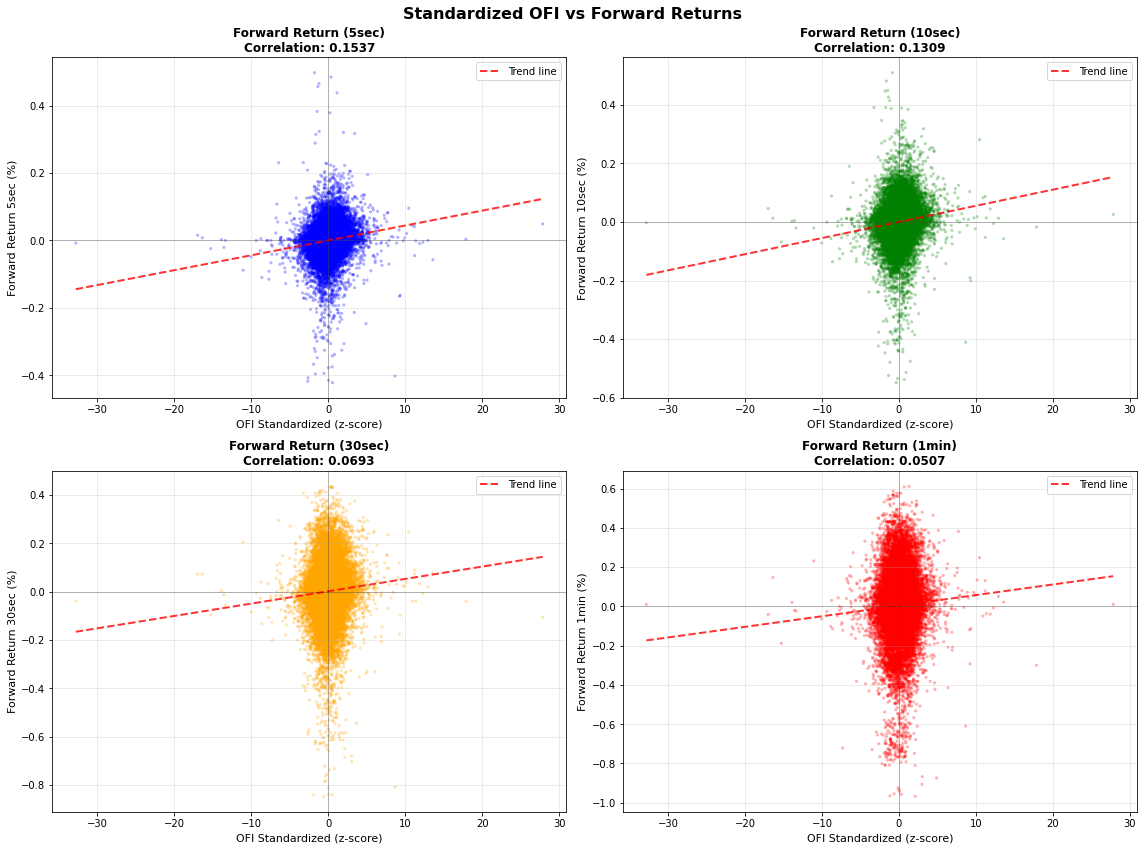


CORRELATION ANALYSIS: OFI_standardized vs Forward Returns
    5sec:   0.1537
   10sec:   0.1309
   30sec:   0.0693
    1min:   0.0507

INTERPRETATION
Positive correlation: Higher OFI (more bids) → Price goes up
Negative correlation: Higher OFI (more bids) → Price goes down (absorption)
Near zero: OFI not predictive of price movement


In [26]:
# Scatter plots: OFI_standardized vs Forward Returns
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values for correlation calculation
df_clean = df[['OFI_standardized', 'fwd_return_5sec', 'fwd_return_10sec', 
               'fwd_return_30sec', 'fwd_return_1min']].dropna()

# Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Standardized OFI vs Forward Returns', fontsize=16, fontweight='bold')

time_windows = ['5sec', '10sec', '30sec', '1min']
colors = ['blue', 'green', 'orange', 'red']

for idx, (window, color) in enumerate(zip(time_windows, colors)):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    x = df_clean['OFI_standardized']
    y = df_clean[f'fwd_return_{window}']
    
    # Scatter plot with transparency
    ax.scatter(x, y, alpha=0.3, s=10, color=color, edgecolors='none')
    
    # Calculate and display correlation
    corr = x.corr(y)
    
    # Add trend line
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    x_line = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label=f'Trend line')
    
    # Add zero lines
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    
    # Labels and title
    ax.set_xlabel('OFI Standardized (z-score)', fontsize=11)
    ax.set_ylabel(f'Forward Return {window} (%)', fontsize=11)
    ax.set_title(f'Forward Return ({window})\nCorrelation: {corr:.4f}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

# Print correlation summary
print("\n" + "=" * 60)
print("CORRELATION ANALYSIS: OFI_standardized vs Forward Returns")
print("=" * 60)
for window in time_windows:
    corr = df_clean['OFI_standardized'].corr(df_clean[f'fwd_return_{window}'])
    print(f"  {window:>6}: {corr:>8.4f}")

print("\n" + "=" * 60)
print("INTERPRETATION")
print("=" * 60)
print("Positive correlation: Higher OFI (more bids) → Price goes up")
print("Negative correlation: Higher OFI (more bids) → Price goes down (absorption)")
print("Near zero: OFI not predictive of price movement")
print("=" * 60)

FORWARD RETURN ANALYSIS BY OFI_STANDARDIZED QUANTILES

Quantile ranges (z-score):
  Q10: [  1.74,  27.83] (mean:   2.67, n= 2623)
  Q5: [ -0.39,  -0.04] (mean:  -0.22, n= 2623)
  Q7: [  0.32,   0.69] (mean:   0.50, n= 2622)
  Q9: [  1.12,   1.74] (mean:   1.40, n= 2623)
  Q4: [ -0.73,  -0.39] (mean:  -0.56, n= 2622)
  Q1: [-32.81,  -1.60] (mean:  -2.39, n= 2623)
  Q2: [ -1.60,  -1.10] (mean:  -1.33, n= 2623)
  Q8: [  0.69,   1.12] (mean:   0.90, n= 2623)
  Q6: [ -0.04,   0.32] (mean:   0.14, n= 2623)
  Q3: [ -1.10,  -0.73] (mean:  -0.91, n= 2623)

MEAN FORWARD RETURNS BY QUANTILE (%)
Quantile          5sec       10sec       30sec        1min
--------------------------------------------------------------------------------
Q1             -0.0099     -0.0116     -0.0096     -0.0081
Q10             0.0136      0.0171      0.0195      0.0235
Q2             -0.0060     -0.0071     -0.0035     -0.0025
Q3             -0.0060     -0.0060     -0.0019     -0.0016
Q4             -0.0040     -0.006

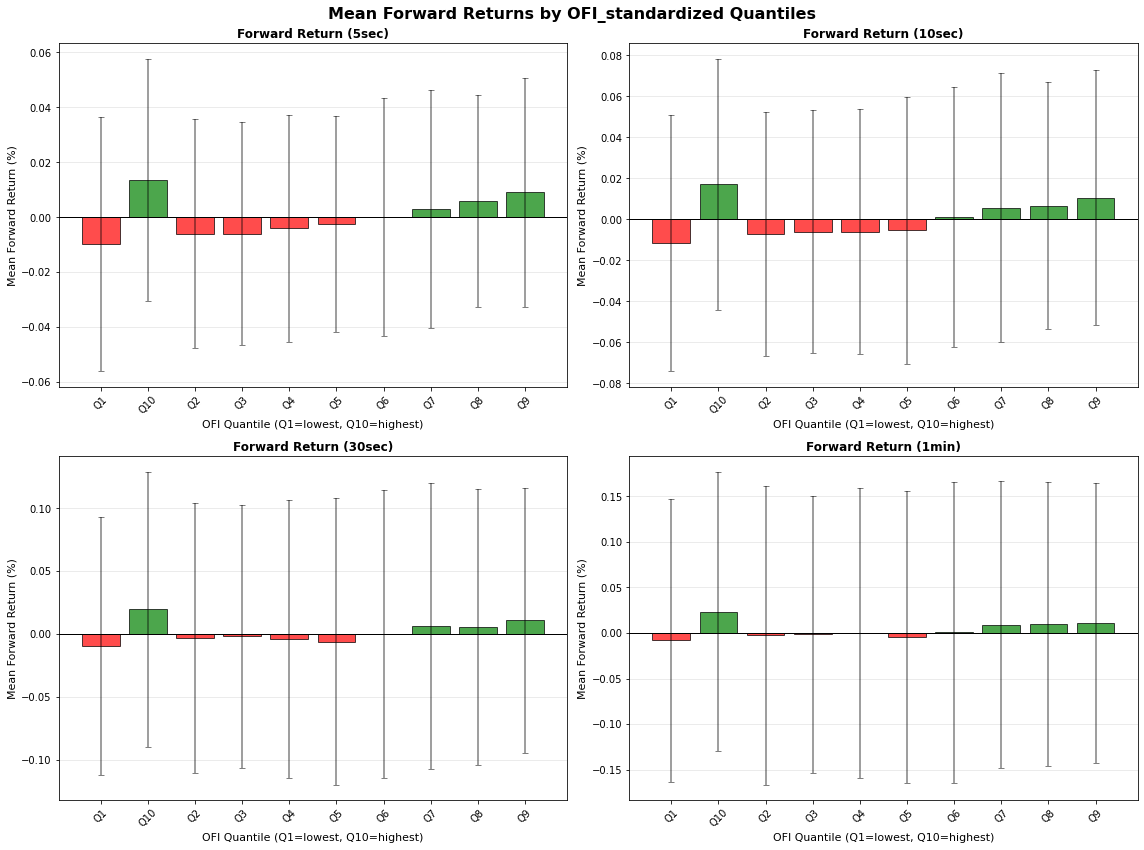


INTERPRETATION
Q1 (lowest OFI): Strong ask-side pressure → Expect negative/lower returns
Q10 (highest OFI): Strong bid-side pressure → Expect positive/higher returns
If Q10 > Q1: OFI is predictive (higher OFI → higher future returns)
If Q10 < Q1: Inverse relationship (liquidity absorption)


In [27]:
# Forward Return Analysis by OFI_standardized Quantiles
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values
df_analysis = df[['OFI_standardized', 'fwd_return_5sec', 'fwd_return_10sec', 
                   'fwd_return_30sec', 'fwd_return_1min']].dropna()

# Create quantile bins for OFI_standardized
n_quantiles = 10
df_analysis['OFI_quantile'] = pd.qcut(df_analysis['OFI_standardized'], 
                                       q=n_quantiles, 
                                       labels=[f'Q{i+1}' for i in range(n_quantiles)],
                                       duplicates='drop')

# Calculate mean forward returns by quantile
time_windows = ['5sec', '10sec', '30sec', '1min']
quantile_stats = {}

print("=" * 80)
print("FORWARD RETURN ANALYSIS BY OFI_STANDARDIZED QUANTILES")
print("=" * 80)
print("\nQuantile ranges (z-score):")

for quantile in df_analysis['OFI_quantile'].unique():
    q_data = df_analysis[df_analysis['OFI_quantile'] == quantile]
    z_min = q_data['OFI_standardized'].min()
    z_max = q_data['OFI_standardized'].max()
    z_mean = q_data['OFI_standardized'].mean()
    count = len(q_data)
    print(f"  {quantile}: [{z_min:>6.2f}, {z_max:>6.2f}] (mean: {z_mean:>6.2f}, n={count:>5})")

# Calculate mean returns by quantile
print("\n" + "=" * 80)
print("MEAN FORWARD RETURNS BY QUANTILE (%)")
print("=" * 80)
print(f"{'Quantile':<10}", end='')
for window in time_windows:
    print(f"{window:>12}", end='')
print()
print("-" * 80)

quantile_results = []
for quantile in sorted(df_analysis['OFI_quantile'].unique()):
    q_data = df_analysis[df_analysis['OFI_quantile'] == quantile]
    row_data = {'quantile': quantile}
    print(f"{quantile:<10}", end='')
    
    for window in time_windows:
        mean_return = q_data[f'fwd_return_{window}'].mean()
        row_data[window] = mean_return
        print(f"{mean_return:>12.4f}", end='')
    print()
    quantile_results.append(row_data)

# Calculate the spread (Q10 - Q1)
print("\n" + "=" * 80)
print("QUANTILE SPREAD ANALYSIS (Q10 - Q1)")
print("=" * 80)
q1_returns = df_analysis[df_analysis['OFI_quantile'] == 'Q1']
q10_returns = df_analysis[df_analysis['OFI_quantile'] == 'Q10']

for window in time_windows:
    q1_mean = q1_returns[f'fwd_return_{window}'].mean()
    q10_mean = q10_returns[f'fwd_return_{window}'].mean()
    spread = q10_mean - q1_mean
    print(f"  {window:>6}: Q1={q1_mean:>8.4f}%, Q10={q10_mean:>8.4f}%, Spread={spread:>8.4f}%")

# Visualization: Bar plot of mean returns by quantile
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Mean Forward Returns by OFI_standardized Quantiles', fontsize=16, fontweight='bold')

for idx, window in enumerate(time_windows):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Prepare data
    quantiles = []
    means = []
    stds = []
    
    for quantile in sorted(df_analysis['OFI_quantile'].unique()):
        q_data = df_analysis[df_analysis['OFI_quantile'] == quantile]
        quantiles.append(quantile)
        means.append(q_data[f'fwd_return_{window}'].mean())
        stds.append(q_data[f'fwd_return_{window}'].std())
    
    # Create bar plot
    x_pos = np.arange(len(quantiles))
    colors = ['red' if m < 0 else 'green' for m in means]
    bars = ax.bar(x_pos, means, color=colors, alpha=0.7, edgecolor='black')
    
    # Add error bars
    ax.errorbar(x_pos, means, yerr=stds, fmt='none', color='black', alpha=0.5, capsize=3)
    
    # Add zero line
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    # Labels
    ax.set_xlabel('OFI Quantile (Q1=lowest, Q10=highest)', fontsize=11)
    ax.set_ylabel(f'Mean Forward Return (%)', fontsize=11)
    ax.set_title(f'Forward Return ({window})', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(quantiles, rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("INTERPRETATION")
print("=" * 80)
print("Q1 (lowest OFI): Strong ask-side pressure → Expect negative/lower returns")
print("Q10 (highest OFI): Strong bid-side pressure → Expect positive/higher returns")
print("If Q10 > Q1: OFI is predictive (higher OFI → higher future returns)")
print("If Q10 < Q1: Inverse relationship (liquidity absorption)")
print("=" * 80)

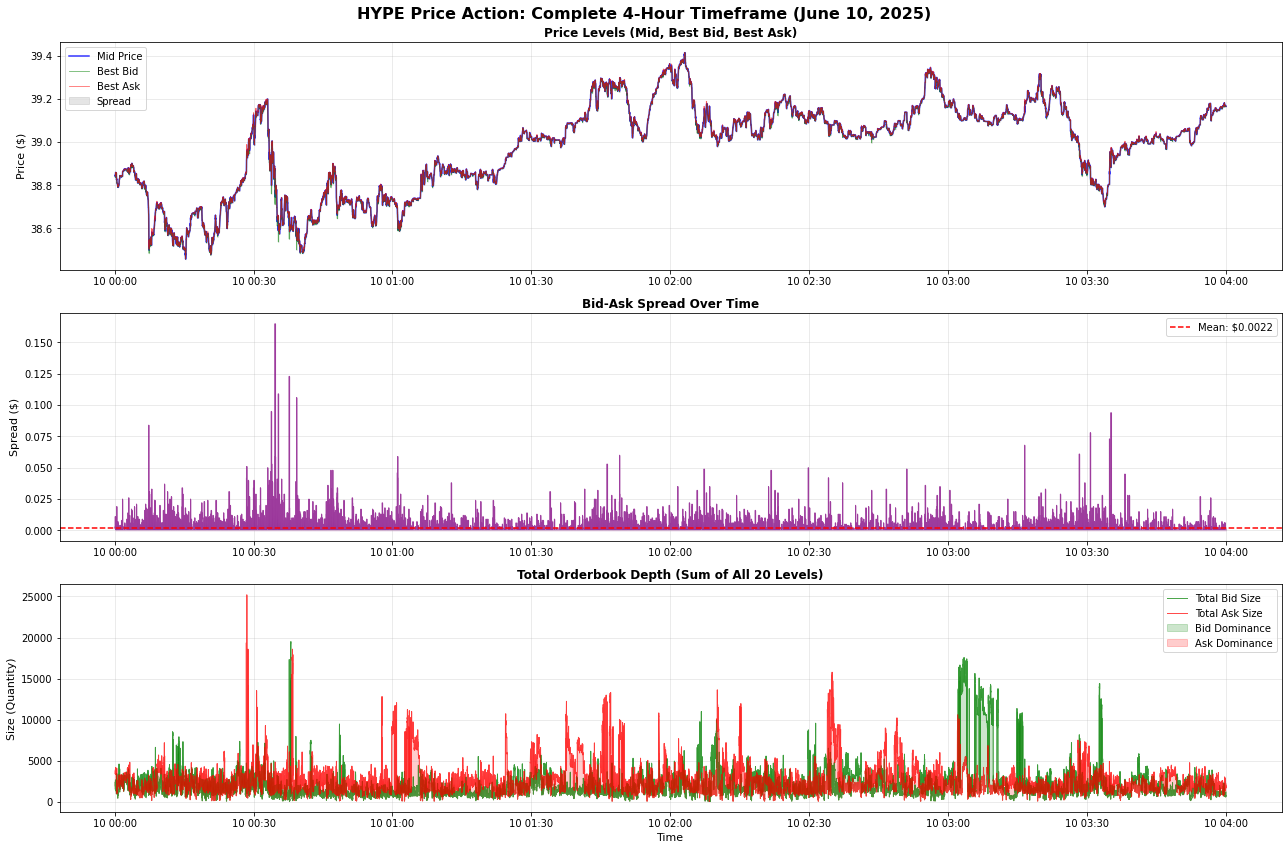


COMPLETE TIMEFRAME SUMMARY
Duration: 2025-06-10 00:00:08.551000 to 2025-06-10 03:59:59
Total observations: 26,337

Price Statistics:
  Starting mid price: $38.846
  Ending mid price: $39.165
  Price change: $0.319 (0.82%)
  Highest: $39.415
  Lowest: $38.457
  Range: $0.957

Spread Statistics:
  Mean spread: $0.0022
  Median spread: $0.0010
  Min spread: $0.0010
  Max spread: $0.1650

Orderbook Depth:
  Avg total bid size: 2096.38
  Avg total ask size: 2587.30
  Avg OFI: -0.1279


In [28]:
# Plot mid price, best bid, and best ask over the complete 4-hour timeframe
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(18, 12))
fig.suptitle('HYPE Price Action: Complete 4-Hour Timeframe (June 10, 2025)', fontsize=16, fontweight='bold')

# Plot 1: Price levels
ax1 = axes[0]
ax1.plot(df['time'], df['mid_price'], color='blue', linewidth=1.5, label='Mid Price', alpha=0.8)
ax1.plot(df['time'], df['best_bid_px'], color='green', linewidth=0.8, label='Best Bid', alpha=0.6)
ax1.plot(df['time'], df['best_ask_px'], color='red', linewidth=0.8, label='Best Ask', alpha=0.6)
ax1.fill_between(df['time'], df['best_bid_px'], df['best_ask_px'], color='gray', alpha=0.2, label='Spread')
ax1.set_ylabel('Price ($)', fontsize=11)
ax1.set_title('Price Levels (Mid, Best Bid, Best Ask)', fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Spread over time
ax2 = axes[1]
ax2.plot(df['time'], df['spread'], color='purple', linewidth=1, alpha=0.7)
ax2.fill_between(df['time'], 0, df['spread'], color='purple', alpha=0.2)
ax2.set_ylabel('Spread ($)', fontsize=11)
ax2.set_title('Bid-Ask Spread Over Time', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
spread_mean = df['spread'].mean()
ax2.axhline(y=spread_mean, color='red', linestyle='--', linewidth=1.5, label=f'Mean: ${spread_mean:.4f}')
ax2.legend(loc='best', fontsize=10)

# Plot 3: Total orderbook depth (total bid size vs total ask size)
ax3 = axes[2]
ax3.plot(df['time'], df['total_bid_size'], color='green', linewidth=1, label='Total Bid Size', alpha=0.7)
ax3.plot(df['time'], df['total_ask_size'], color='red', linewidth=1, label='Total Ask Size', alpha=0.7)
ax3.fill_between(df['time'], df['total_bid_size'], df['total_ask_size'], 
                 where=(df['total_bid_size'] >= df['total_ask_size']), color='green', alpha=0.2, label='Bid Dominance')
ax3.fill_between(df['time'], df['total_bid_size'], df['total_ask_size'], 
                 where=(df['total_bid_size'] < df['total_ask_size']), color='red', alpha=0.2, label='Ask Dominance')
ax3.set_xlabel('Time', fontsize=11)
ax3.set_ylabel('Size (Quantity)', fontsize=11)
ax3.set_title('Total Orderbook Depth (Sum of All 20 Levels)', fontsize=12, fontweight='bold')
ax3.legend(loc='best', fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 80)
print("COMPLETE TIMEFRAME SUMMARY")
print("=" * 80)
print(f"Duration: {df['time'].min()} to {df['time'].max()}")
print(f"Total observations: {len(df):,}")
print(f"\nPrice Statistics:")
print(f"  Starting mid price: ${df['mid_price'].iloc[0]:.3f}")
print(f"  Ending mid price: ${df['mid_price'].iloc[-1]:.3f}")
print(f"  Price change: ${df['mid_price'].iloc[-1] - df['mid_price'].iloc[0]:.3f} ({((df['mid_price'].iloc[-1] / df['mid_price'].iloc[0]) - 1) * 100:.2f}%)")
print(f"  Highest: ${df['mid_price'].max():.3f}")
print(f"  Lowest: ${df['mid_price'].min():.3f}")
print(f"  Range: ${df['mid_price'].max() - df['mid_price'].min():.3f}")
print(f"\nSpread Statistics:")
print(f"  Mean spread: ${df['spread'].mean():.4f}")
print(f"  Median spread: ${df['spread'].median():.4f}")
print(f"  Min spread: ${df['spread'].min():.4f}")
print(f"  Max spread: ${df['spread'].max():.4f}")
print(f"\nOrderbook Depth:")
print(f"  Avg total bid size: {df['total_bid_size'].mean():.2f}")
print(f"  Avg total ask size: {df['total_ask_size'].mean():.2f}")
print(f"  Avg OFI: {df['OFI'].mean():.4f}")
print("=" * 80)

In [29]:

import os
import json
import pandas as pd
from IPython.display import display

# Add repo root to sys.path so we can import local modules
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from hyperliquid_snapshots.decompress import decompress_lz4_file

# Parameters — adjust if needed
date_str = '20250610'  # matches your data path
depth_levels = [5, 10, 15, 20]
std_windows = [('5s', '5s'), ('10s', '10s'), ('20s', '20s'), ('30s', '30s'), ('1min', '60s')]
fwd_windows = ['5sec', '10sec', '30sec', '1min']

# Determine hours to scan from existing df or default
try:
    hrs = hours
except NameError:
    # Avoid referencing df if it's not defined (prevents NameError when running this cell standalone)
    if 'df' in globals() and 'hour' in df.columns:
        hrs = sorted(pd.Series(df['hour']).dropna().unique().tolist())
    else:
        hrs = [0, 1, 2, 3]  # fallback

# Build OFI by depth from raw snapshots
ofi_rows = []
for hour in hrs:
    lz4_path = os.path.join('..', 'data', 'market_data', date_str, str(int(hour)), 'l2Book', 'HYPE.lz4')
    json_path = lz4_path.replace('.lz4', '')

    # Decompress if needed
    if not os.path.exists(json_path) and os.path.exists(lz4_path):
        decompress_lz4_file(lz4_path, remove_src=False)
    if not os.path.exists(json_path):
        continue

    with open(json_path, 'r') as f:
        for line in f:
            if not line.strip():
                continue
            rec = json.loads(line)
            raw = rec.get('raw', {}).get('data', {})
            ts = raw.get('time', None)
            levels = raw.get('levels', [])
            if ts is None or len(levels) < 2:
                continue

            bids, asks = levels[0], levels[1]
            bid_sizes = [float(x['sz']) for x in bids]
            ask_sizes = [float(x['sz']) for x in asks]

            row = {'time': ts, 'hour': int(hour)}
            for n in depth_levels:
                bsum = sum(bid_sizes[:min(n, len(bid_sizes))])
                asum = sum(ask_sizes[:min(n, len(ask_sizes))])
                denom = bsum + asum
                row[f'OFI_{n}'] = ((bsum - asum) / denom) if denom > 0 else None
            ofi_rows.append(row)

ofi_df = pd.DataFrame(ofi_rows)
if ofi_df.empty:
    raise RuntimeError('No OFI rows computed — check date_str/hours and data availability')

# Normalize/convert times to a comparable dtype
ofi_df['time'] = pd.to_datetime(ofi_df['time'], unit='ms')
# If the notebook already has a `df` with timezone-aware times, convert both to naive UTC for safe comparison
if 'df' in globals():
    if pd.api.types.is_datetime64tz_dtype(df['time']):
        df['time'] = df['time'].dt.tz_convert('UTC').dt.tz_localize(None)
    if pd.api.types.is_datetime64tz_dtype(ofi_df['time']):
        ofi_df['time'] = ofi_df['time'].dt.tz_convert('UTC').dt.tz_localize(None)
else:
    if pd.api.types.is_datetime64tz_dtype(ofi_df['time']):
        ofi_df['time'] = ofi_df['time'].dt.tz_convert('UTC').dt.tz_localize(None)

ofi_df = ofi_df.sort_values('time').reset_index(drop=True)

# Merge OFI depth into main df on exact timestamp (asof with zero tolerance)
merge_cols = ['time'] + [f'OFI_{n}' for n in depth_levels]
# Ensure df exists before merging — if missing, build a minimal df from raw snapshots as fallback
if 'df' not in globals():
    all_rows = []
    for hour in hrs:
        lz4_path = os.path.join('..', 'data', 'market_data', date_str, str(int(hour)), 'l2Book', 'HYPE.lz4')
        json_path = lz4_path.replace('.lz4', '')
        if not os.path.exists(json_path) and os.path.exists(lz4_path):
            decompress_lz4_file(lz4_path, remove_src=False)
        if not os.path.exists(json_path):
            continue
        with open(json_path, 'r') as f:
            for line in f:
                if not line.strip():
                    continue
                record = json.loads(line)
                raw_data = record.get('raw', {}).get('data', {})
                ts = raw_data.get('time', None)
                coin = raw_data.get('coin', None)
                levels = raw_data.get('levels', [])
                if ts is None or len(levels) < 2:
                    continue
                bids, asks = levels[0], levels[1]
                best_bid_px = float(bids[0]['px']) if bids else None
                best_bid_sz = float(bids[0]['sz']) if bids else None
                best_ask_px = float(asks[0]['px']) if asks else None
                best_ask_sz = float(asks[0]['sz']) if asks else None
                mid_price = (best_bid_px + best_ask_px) / 2 if (best_bid_px is not None and best_ask_px is not None) else None
                spread = (best_ask_px - best_bid_px) if (best_bid_px is not None and best_ask_px is not None) else None
                total_bid_size = sum(float(b['sz']) for b in bids) if bids else 0.0
                total_ask_size = sum(float(a['sz']) for a in asks) if asks else 0.0
                all_rows.append({
                    'time': ts,
                    'coin': coin,
                    'hour': int(hour),
                    'best_bid_px': best_bid_px,
                    'best_bid_sz': best_bid_sz,
                    'best_ask_px': best_ask_px,
                    'best_ask_sz': best_ask_sz,
                    'mid_price': mid_price,
                    'spread': spread,
                    'total_bid_size': total_bid_size,
                    'total_ask_size': total_ask_size
                })
    df = pd.DataFrame(all_rows)
    if df.empty:
        raise RuntimeError('Unable to build fallback df: no data found for given hours/date_str')
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df = df.sort_values('time').reset_index(drop=True)
    print(f'✓ Built fallback df from raw snapshots: {len(df)} rows')
df = pd.merge_asof(
    df.sort_values('time'),
    ofi_df[merge_cols].sort_values('time'),
    on='time',
    direction='nearest',
    tolerance=pd.Timedelta(milliseconds=0)
)

# Helper: ensure forward returns exist (compute if missing)
def _ensure_forward_returns(df_in):
    sec_map = {'5sec': 5, '10sec': 10, '30sec': 30, '1min': 60}
    df_in = df_in.sort_values('time').reset_index(drop=True)
    for name, secs in sec_map.items():
        # Recompute unconditionally to keep code simple
        df_in[f'future_time_{name}'] = df_in['time'] + pd.Timedelta(seconds=secs)
        df_future = df_in[['time', 'mid_price']].rename(columns={'time': 'future_time', 'mid_price': 'future_price'})
        df_in = pd.merge_asof(df_in, df_future, left_on=f'future_time_{name}', right_on='future_time', direction='nearest', tolerance=pd.Timedelta(seconds=2), suffixes=('', f'_{name}'))
        df_in[f'fwd_return_{name}'] = ((df_in['future_price'] - df_in['mid_price']) / df_in['mid_price']) * 100
        df_in = df_in.drop(columns=[f'future_time_{name}', 'future_time', 'future_price'])
    return df_in

# Compute forward returns if any are missing
missing_any = any((f'fwd_return_{fw}' not in df.columns) for fw in fwd_windows)
if missing_any:
    df = _ensure_forward_returns(df)

# Standardize OFI for each depth and window (time-based rolling, closed='left' to avoid look-ahead)
for n in depth_levels:
    col = f'OFI_{n}'
    if col not in df.columns:
        continue
    s = df.set_index('time')[col]
    for label, win in std_windows:
        mean = s.rolling(win, closed='left').mean()
        std = s.rolling(win, closed='left').std()
        z = (s - mean) / std
        df[f'OFI_{n}_z_{label}'] = z.values

# Build correlation table between standardized OFI and forward returns
missing_fwd = [fw for fw in fwd_windows if f'fwd_return_{fw}' not in df.columns]
if missing_fwd:
    # As a final fallback, compute the missing ones
    df = _ensure_forward_returns(df)

results = []
for n in depth_levels:
    for label, _ in std_windows:
        zcol = f'OFI_{n}_z_{label}'
        if zcol not in df.columns:
            continue
        for fwd in fwd_windows:
            rcol = f'fwd_return_{fwd}'
            tmp = df[[zcol, rcol]].dropna()
            corr = tmp[zcol].corr(tmp[rcol]) if len(tmp) >= 10 else float('nan')
            results.append({
                'levels': n,
                'std_window': label,
                'fwd_horizon': fwd,
                'corr': corr,
                'n': len(tmp)
            })

corr_table = pd.DataFrame(results).sort_values(['levels', 'std_window', 'fwd_horizon']).reset_index(drop=True)
print('Correlation table (standardized OFI vs forward returns):')
display(corr_table)

# Pivot for readability (levels x std_window rows, forward horizons as columns)
pivot = corr_table.pivot_table(index=['levels', 'std_window'], columns='fwd_horizon', values='corr')
print('\nPivot (corr):')
display(pivot)

C:\Users\rosha\AppData\Local\Temp\ipykernel_24508\3994332026.py:72: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(df['time']):
C:\Users\rosha\AppData\Local\Temp\ipykernel_24508\3994332026.py:74: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(ofi_df['time']):


Correlation table (standardized OFI vs forward returns):


,levels,std_window,fwd_horizon,corr,n
0,5,10s,10sec,0.106106,26320
1,5,10s,1min,0.038067,26228
2,5,10s,30sec,0.058977,26283
3,5,10s,5sec,0.144136,26329
4,5,1min,10sec,0.133936,26320
...,...,...,...,...,...
75,20,30s,5sec,0.181028,26329
76,20,5s,10sec,0.094927,26320
77,20,5s,1min,0.040169,26228
78,20,5s,30sec,0.051389,26283



Pivot (corr):


fwd_horizon           10sec      1min     30sec      5sec
levels std_window                                        
5      10s         0.106106  0.038067  0.058977  0.144136
       1min        0.133936  0.059119  0.087065  0.188648
       20s         0.120688  0.047845  0.075217  0.172899
       30s         0.125034  0.050247  0.082387  0.178836
       5s          0.060242  0.024195  0.034707  0.081286
10     10s         0.113951  0.041814  0.061488  0.147659
       1min        0.136366  0.052534  0.075620  0.181275
       20s         0.135112  0.047428  0.077041  0.173536
       30s         0.131821  0.046288  0.079257  0.174826
       5s          0.083030  0.030669  0.044961  0.108867
15     10s         0.122837  0.044003  0.065379  0.147923
       1min        0.144051  0.059570  0.079585  0.180544
       20s         0.145224  0.050494  0.078743  0.172837
       30s         0.141153  0.049832  0.080314  0.174741
       5s          0.090787  0.035154  0.048156  0.112386
20     10s         0.130813  0.050727  0.069321  0.153435
       1min        0.148037  0.057445  0.077868  0.180289
       20s         0.152032  0.056045  0.081159  0.176134
       30s         0.150416  0.052428  0.080429  0.181028
       5s          0.094927  0.040169  0.051389  0.117745

In [30]:
# Analyze correlation table to find best settings
import pandas as pd
from IPython.display import display

if 'corr_table' not in globals():
    raise RuntimeError("corr_table is not available. Run the OFI correlation cell first.")

# Drop NaNs and sort overall
ct = corr_table.dropna(subset=['corr']).copy()
ct_sorted = ct.sort_values('corr', ascending=False)

print("Top 10 combinations by correlation (higher is better):")
display(ct_sorted.head(10))

# Best per forward horizon
idx_best_horizon = ct.groupby('fwd_horizon')['corr'].idxmax()
best_per_horizon = ct.loc[idx_best_horizon].sort_values('corr', ascending=False)
print("\nBest combination per forward horizon:")
display(best_per_horizon)

# Best per standardization window
idx_best_std = ct.groupby('std_window')['corr'].idxmax()
best_per_std = ct.loc[idx_best_std].sort_values('corr', ascending=False)
print("\nBest combination per standardization window:")
display(best_per_std)

# Best per levels (depth)
idx_best_levels = ct.groupby('levels')['corr'].idxmax()
best_per_levels = ct.loc[idx_best_levels].sort_values('corr', ascending=False)
print("\nBest combination per depth (levels):")
display(best_per_levels)


Top 10 combinations by correlation (higher is better):


,levels,std_window,fwd_horizon,corr,n
7,5,1min,5sec,0.188648,26329
27,10,1min,5sec,0.181275,26329
75,20,30s,5sec,0.181028,26329
47,15,1min,5sec,0.180544,26329
67,20,1min,5sec,0.180289,26329
15,5,30s,5sec,0.178836,26329
71,20,20s,5sec,0.176134,26329
35,10,30s,5sec,0.174826,26329
55,15,30s,5sec,0.174741,26329
31,10,20s,5sec,0.173536,26329



Best combination per forward horizon:


,levels,std_window,fwd_horizon,corr,n
7,5,1min,5sec,0.188648,26329
68,20,20s,10sec,0.152032,26320
6,5,1min,30sec,0.087065,26283
45,15,1min,1min,0.059570,26228



Best combination per standardization window:


,levels,std_window,fwd_horizon,corr,n
7,5,1min,5sec,0.188648,26329
75,20,30s,5sec,0.181028,26329
71,20,20s,5sec,0.176134,26329
63,20,10s,5sec,0.153435,26329
79,20,5s,5sec,0.117745,26329



Best combination per depth (levels):


,levels,std_window,fwd_horizon,corr,n
7,5,1min,5sec,0.188648,26329
27,10,1min,5sec,0.181275,26329
75,20,30s,5sec,0.181028,26329
47,15,1min,5sec,0.180544,26329


Last rolling window regression:
Intercept: -0.0017, Coef: 0.0000
Current OFI_5_z_1min: -0.6496
Predicted next 5sec return: -0.0017%


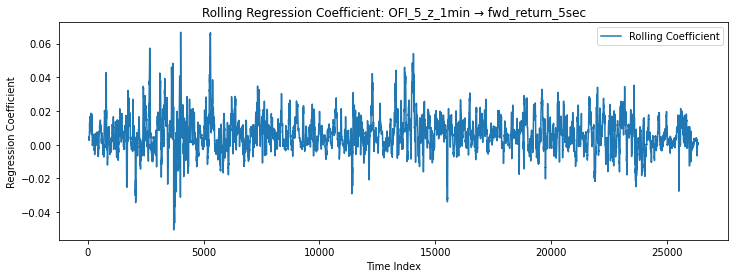

In [31]:
# Rolling regression: OFI_5_z_1min (past 1min) → fwd_return_5sec
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

window_size = 60  # 1 minute, assuming 1-second snapshots; adjust if needed
zcol = 'OFI_5_z_1min'
rcol = 'fwd_return_5sec'

df_roll = df[[zcol, rcol]].dropna().reset_index(drop=True)
coefs = []
intercepts = []
preds = []
times = []

for i in range(window_size, len(df_roll)):
    X_win = df_roll[zcol].iloc[i-window_size:i].values.reshape(-1, 1)
    y_win = df_roll[rcol].iloc[i-window_size:i].values
    model = LinearRegression().fit(X_win, y_win)
    coefs.append(model.coef_[0])
    intercepts.append(model.intercept_)
    # Predict next 5sec return using current OFI value
    pred = model.predict([[df_roll[zcol].iloc[i]]])[0]
    preds.append(pred)
    times.append(df_roll.index[i])

print(f"Last rolling window regression:")
print(f"Intercept: {intercepts[-1]:.4f}, Coef: {coefs[-1]:.4f}")
print(f"Current OFI_5_z_1min: {df_roll[zcol].iloc[-1]:.4f}")
print(f"Predicted next 5sec return: {preds[-1]:.4f}%")

# Optional: plot rolling coefficients
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(times, coefs, label='Rolling Coefficient')
plt.xlabel('Time Index')
plt.ylabel('Regression Coefficient')
plt.title('Rolling Regression Coefficient: OFI_5_z_1min → fwd_return_5sec')
plt.legend()
plt.show()

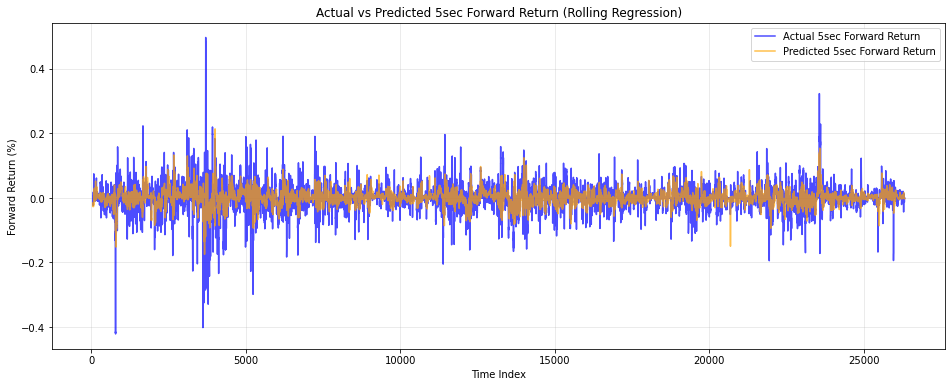

Mean Squared Error: 0.001732
R^2 Score: 0.0463


In [32]:
# Plot actual mid price and predicted price (using rolling regression predictions)
import matplotlib.pyplot as plt
import numpy as np

# Use df_roll for actual returns, preds for predicted returns, times for time indices
# Align times to actual timestamps from df_roll
actual_times = df_roll.index[window_size:]
actual_prices = df_roll[rcol].iloc[window_size:].values  # actual forward returns
predicted_prices = np.array(preds)

plt.figure(figsize=(16,6))
plt.plot(actual_times, actual_prices, label='Actual 5sec Forward Return', color='blue', alpha=0.7)
plt.plot(actual_times, predicted_prices, label='Predicted 5sec Forward Return', color='orange', alpha=0.7)
plt.xlabel('Time Index')
plt.ylabel('Forward Return (%)')
plt.title('Actual vs Predicted 5sec Forward Return (Rolling Regression)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Optionally, print summary statistics
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)
print(f"Mean Squared Error: {mse:.6f}")
print(f"R^2 Score: {r2:.4f}")

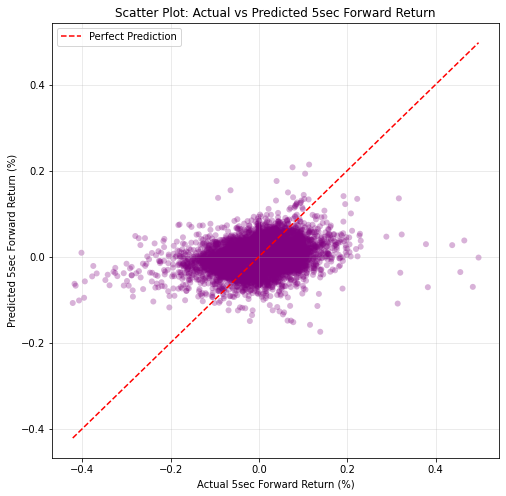

Correlation (Actual vs Predicted): 0.2964


In [33]:
# Scatter plot: Actual vs Predicted 5sec Forward Return
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,8))
plt.scatter(actual_prices, predicted_prices, alpha=0.3, color='purple', edgecolors='none')
plt.plot([actual_prices.min(), actual_prices.max()], [actual_prices.min(), actual_prices.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual 5sec Forward Return (%)')
plt.ylabel('Predicted 5sec Forward Return (%)')
plt.title('Scatter Plot: Actual vs Predicted 5sec Forward Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print correlation
corr = np.corrcoef(actual_prices, predicted_prices)[0,1]
print(f"Correlation (Actual vs Predicted): {corr:.4f}")

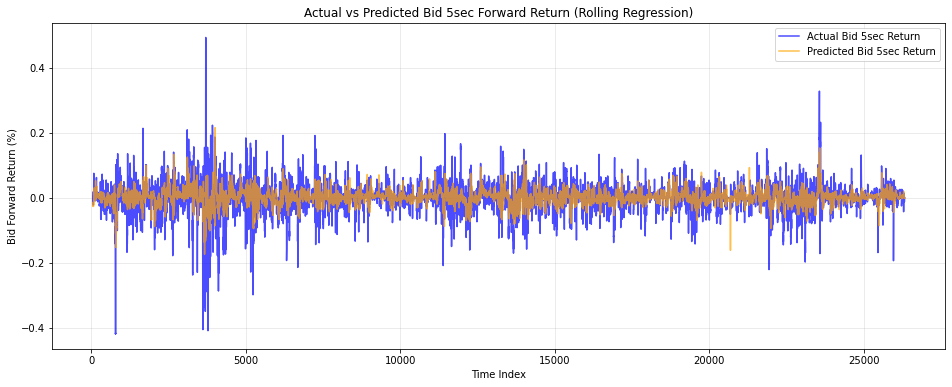

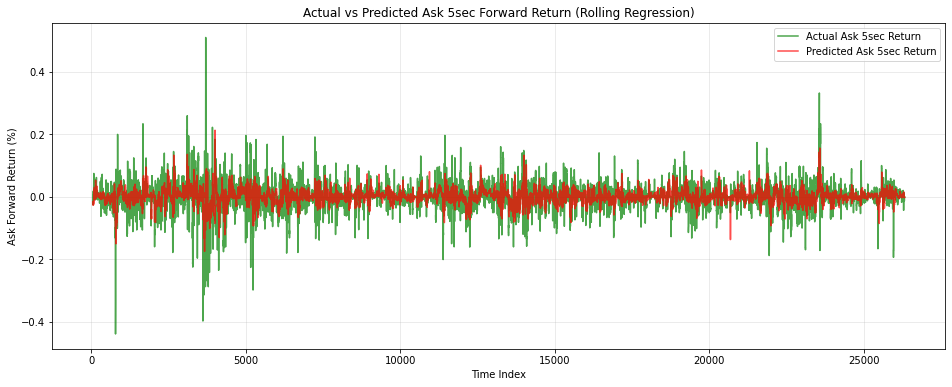

Bid Return - Mean Squared Error: 0.001812, R^2 Score: 0.0436
Ask Return - Mean Squared Error: 0.001756, R^2 Score: 0.0436


In [34]:
# Predict bid and ask forward returns separately using rolling regression
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Calculate bid and ask forward returns (if not already present)
df['future_bid_px_5sec'] = df['time'] + pd.Timedelta(seconds=5)
df['future_ask_px_5sec'] = df['time'] + pd.Timedelta(seconds=5)

# Merge to get future bid and ask prices
df_bid_future = df[['time', 'best_bid_px']].rename(columns={'time': 'future_bid_px_5sec', 'best_bid_px': 'future_bid_px'})
df_ask_future = df[['time', 'best_ask_px']].rename(columns={'time': 'future_ask_px_5sec', 'best_ask_px': 'future_ask_px'})
df = pd.merge_asof(df, df_bid_future, left_on='future_bid_px_5sec', right_on='future_bid_px_5sec', direction='nearest', tolerance=pd.Timedelta(seconds=2))
df = pd.merge_asof(df, df_ask_future, left_on='future_ask_px_5sec', right_on='future_ask_px_5sec', direction='nearest', tolerance=pd.Timedelta(seconds=2))

df['bid_return_5sec'] = ((df['future_bid_px'] - df['best_bid_px']) / df['best_bid_px']) * 100
df['ask_return_5sec'] = ((df['future_ask_px'] - df['best_ask_px']) / df['best_ask_px']) * 100

# Rolling regression for bid return
window_size = 60  # 1 minute
zcol = 'OFI_5_z_1min'
bidcol = 'bid_return_5sec'
askcol = 'ask_return_5sec'

df_roll_bid = df[[zcol, bidcol]].dropna().reset_index(drop=True)
bid_coefs = []
bid_intercepts = []
bid_preds = []
bid_times = []
for i in range(window_size, len(df_roll_bid)):
    X_win = df_roll_bid[zcol].iloc[i-window_size:i].values.reshape(-1, 1)
    y_win = df_roll_bid[bidcol].iloc[i-window_size:i].values
    model = LinearRegression().fit(X_win, y_win)
    bid_coefs.append(model.coef_[0])
    bid_intercepts.append(model.intercept_)
    pred = model.predict([[df_roll_bid[zcol].iloc[i]]])[0]
    bid_preds.append(pred)
    bid_times.append(df_roll_bid.index[i])

# Rolling regression for ask return
df_roll_ask = df[[zcol, askcol]].dropna().reset_index(drop=True)
ask_coefs = []
ask_intercepts = []
ask_preds = []
ask_times = []
for i in range(window_size, len(df_roll_ask)):
    X_win = df_roll_ask[zcol].iloc[i-window_size:i].values.reshape(-1, 1)
    y_win = df_roll_ask[askcol].iloc[i-window_size:i].values
    model = LinearRegression().fit(X_win, y_win)
    ask_coefs.append(model.coef_[0])
    ask_intercepts.append(model.intercept_)
    pred = model.predict([[df_roll_ask[zcol].iloc[i]]])[0]
    ask_preds.append(pred)
    ask_times.append(df_roll_ask.index[i])

# Plot actual vs predicted bid returns
plt.figure(figsize=(16,6))
plt.plot(bid_times, df_roll_bid[bidcol].iloc[window_size:], label='Actual Bid 5sec Return', color='blue', alpha=0.7)
plt.plot(bid_times, bid_preds, label='Predicted Bid 5sec Return', color='orange', alpha=0.7)
plt.xlabel('Time Index')
plt.ylabel('Bid Forward Return (%)')
plt.title('Actual vs Predicted Bid 5sec Forward Return (Rolling Regression)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot actual vs predicted ask returns
plt.figure(figsize=(16,6))
plt.plot(ask_times, df_roll_ask[askcol].iloc[window_size:], label='Actual Ask 5sec Return', color='green', alpha=0.7)
plt.plot(ask_times, ask_preds, label='Predicted Ask 5sec Return', color='red', alpha=0.7)
plt.xlabel('Time Index')
plt.ylabel('Ask Forward Return (%)')
plt.title('Actual vs Predicted Ask 5sec Forward Return (Rolling Regression)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print summary statistics
from sklearn.metrics import mean_squared_error, r2_score
bid_mse = mean_squared_error(df_roll_bid[bidcol].iloc[window_size:], bid_preds)
bid_r2 = r2_score(df_roll_bid[bidcol].iloc[window_size:], bid_preds)
ask_mse = mean_squared_error(df_roll_ask[askcol].iloc[window_size:], ask_preds)
ask_r2 = r2_score(df_roll_ask[askcol].iloc[window_size:], ask_preds)
print(f"Bid Return - Mean Squared Error: {bid_mse:.6f}, R^2 Score: {bid_r2:.4f}")
print(f"Ask Return - Mean Squared Error: {ask_mse:.6f}, R^2 Score: {ask_r2:.4f}")

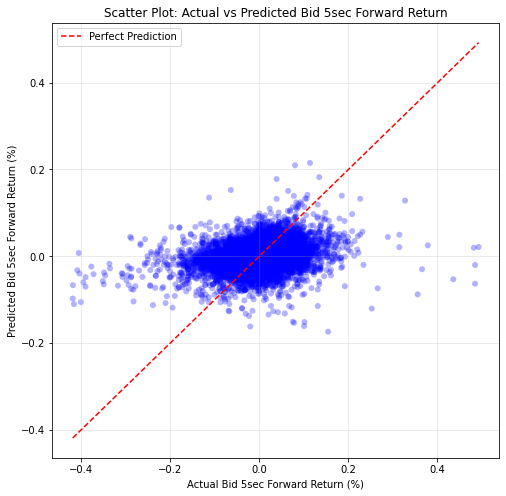

Bid Return Correlation (Actual vs Predicted): 0.2895


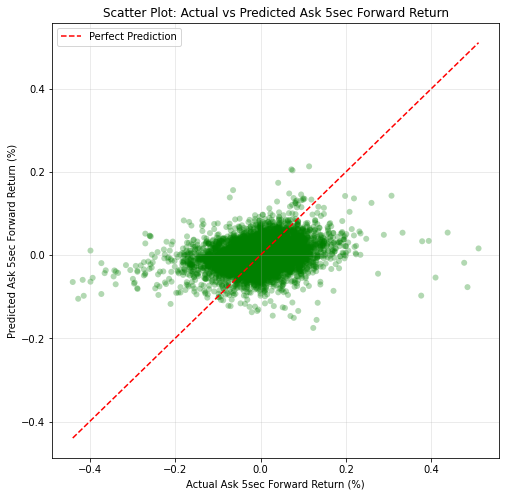

Ask Return Correlation (Actual vs Predicted): 0.2934


In [35]:
# Scatter plot: Actual vs Predicted Bid and Ask 5sec Forward Return
import matplotlib.pyplot as plt
import numpy as np

# Bid return scatter plot
plt.figure(figsize=(8,8))
plt.scatter(df_roll_bid[bidcol].iloc[window_size:], bid_preds, alpha=0.3, color='blue', edgecolors='none')
plt.plot([df_roll_bid[bidcol].min(), df_roll_bid[bidcol].max()], [df_roll_bid[bidcol].min(), df_roll_bid[bidcol].max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Bid 5sec Forward Return (%)')
plt.ylabel('Predicted Bid 5sec Forward Return (%)')
plt.title('Scatter Plot: Actual vs Predicted Bid 5sec Forward Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

bid_corr = np.corrcoef(df_roll_bid[bidcol].iloc[window_size:], bid_preds)[0,1]
print(f"Bid Return Correlation (Actual vs Predicted): {bid_corr:.4f}")

# Ask return scatter plot
plt.figure(figsize=(8,8))
plt.scatter(df_roll_ask[askcol].iloc[window_size:], ask_preds, alpha=0.3, color='green', edgecolors='none')
plt.plot([df_roll_ask[askcol].min(), df_roll_ask[askcol].max()], [df_roll_ask[askcol].min(), df_roll_ask[askcol].max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Ask 5sec Forward Return (%)')
plt.ylabel('Predicted Ask 5sec Forward Return (%)')
plt.title('Scatter Plot: Actual vs Predicted Ask 5sec Forward Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

ask_corr = np.corrcoef(df_roll_ask[askcol].iloc[window_size:], ask_preds)[0,1]
print(f"Ask Return Correlation (Actual vs Predicted): {ask_corr:.4f}")

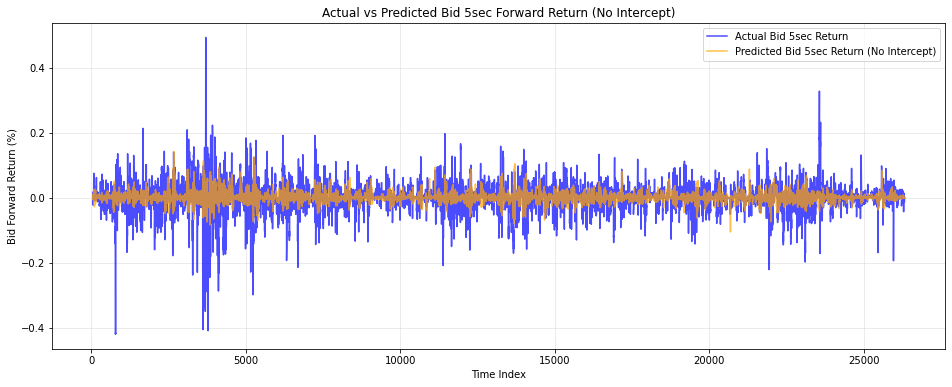

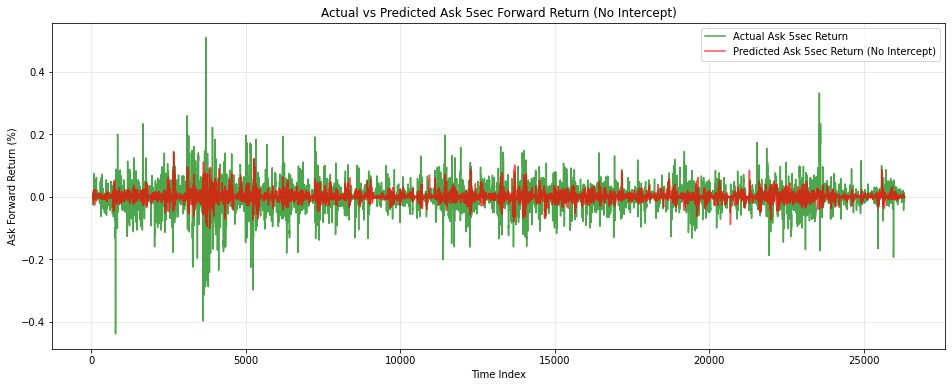

Bid Return (No Intercept) - Mean Squared Error: 0.001837, R^2 Score: 0.0302
Ask Return (No Intercept) - Mean Squared Error: 0.001775, R^2 Score: 0.0333


In [36]:
# Rolling regression for bid and ask returns WITHOUT intercept
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Fit without intercept
window_size = 60  # 1 minute
zcol = 'OFI_5_z_1min'
bidcol = 'bid_return_5sec'
askcol = 'ask_return_5sec'

# Bid
bid_coefs_no_intercept = []
bid_preds_no_intercept = []
bid_times_no_intercept = []
df_roll_bid = df[[zcol, bidcol]].dropna().reset_index(drop=True)
for i in range(window_size, len(df_roll_bid)):
    X_win = df_roll_bid[zcol].iloc[i-window_size:i].values.reshape(-1, 1)
    y_win = df_roll_bid[bidcol].iloc[i-window_size:i].values
    model = LinearRegression(fit_intercept=False).fit(X_win, y_win)
    bid_coefs_no_intercept.append(model.coef_[0])
    pred = model.predict([[df_roll_bid[zcol].iloc[i]]])[0]
    bid_preds_no_intercept.append(pred)
    bid_times_no_intercept.append(df_roll_bid.index[i])

# Ask
ask_coefs_no_intercept = []
ask_preds_no_intercept = []
ask_times_no_intercept = []
df_roll_ask = df[[zcol, askcol]].dropna().reset_index(drop=True)
for i in range(window_size, len(df_roll_ask)):
    X_win = df_roll_ask[zcol].iloc[i-window_size:i].values.reshape(-1, 1)
    y_win = df_roll_ask[askcol].iloc[i-window_size:i].values
    model = LinearRegression(fit_intercept=False).fit(X_win, y_win)
    ask_coefs_no_intercept.append(model.coef_[0])
    pred = model.predict([[df_roll_ask[zcol].iloc[i]]])[0]
    ask_preds_no_intercept.append(pred)
    ask_times_no_intercept.append(df_roll_ask.index[i])

# Plot actual vs predicted bid returns (no intercept)
plt.figure(figsize=(16,6))
plt.plot(bid_times_no_intercept, df_roll_bid[bidcol].iloc[window_size:], label='Actual Bid 5sec Return', color='blue', alpha=0.7)
plt.plot(bid_times_no_intercept, bid_preds_no_intercept, label='Predicted Bid 5sec Return (No Intercept)', color='orange', alpha=0.7)
plt.xlabel('Time Index')
plt.ylabel('Bid Forward Return (%)')
plt.title('Actual vs Predicted Bid 5sec Forward Return (No Intercept)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot actual vs predicted ask returns (no intercept)
plt.figure(figsize=(16,6))
plt.plot(ask_times_no_intercept, df_roll_ask[askcol].iloc[window_size:], label='Actual Ask 5sec Return', color='green', alpha=0.7)
plt.plot(ask_times_no_intercept, ask_preds_no_intercept, label='Predicted Ask 5sec Return (No Intercept)', color='red', alpha=0.7)
plt.xlabel('Time Index')
plt.ylabel('Ask Forward Return (%)')
plt.title('Actual vs Predicted Ask 5sec Forward Return (No Intercept)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print summary statistics
from sklearn.metrics import mean_squared_error, r2_score
bid_mse_no_intercept = mean_squared_error(df_roll_bid[bidcol].iloc[window_size:], bid_preds_no_intercept)
bid_r2_no_intercept = r2_score(df_roll_bid[bidcol].iloc[window_size:], bid_preds_no_intercept)
ask_mse_no_intercept = mean_squared_error(df_roll_ask[askcol].iloc[window_size:], ask_preds_no_intercept)
ask_r2_no_intercept = r2_score(df_roll_ask[askcol].iloc[window_size:], ask_preds_no_intercept)
print(f"Bid Return (No Intercept) - Mean Squared Error: {bid_mse_no_intercept:.6f}, R^2 Score: {bid_r2_no_intercept:.4f}")
print(f"Ask Return (No Intercept) - Mean Squared Error: {ask_mse_no_intercept:.6f}, R^2 Score: {ask_r2_no_intercept:.4f}")

In [ ]:
# Normalize bid and ask returns (z-score) and run rolling regression without intercept
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

window_size = 60  # 1 minute
zcol = 'OFI_5_z_1min'
bidcol = 'bid_return_5sec'
askcol = 'ask_return_5sec'

# Calculate rolling mean and std for bid and ask returns
df['bid_return_5sec_mean_1min'] = df.set_index('time')[bidcol].rolling('60s', closed='left').mean().values
df['bid_return_5sec_std_1min'] = df.set_index('time')[bidcol].rolling('60s', closed='left').std().values
df['ask_return_5sec_mean_1min'] = df.set_index('time')[askcol].rolling('60s', closed='left').mean().values
df['ask_return_5sec_std_1min'] = df.set_index('time')[askcol].rolling('60s', closed='left').std().values

# Z-score normalization
df['bid_return_5sec_z_1min'] = (df[bidcol] - df['bid_return_5sec_mean_1min']) / df['bid_return_5sec_std_1min']
df['ask_return_5sec_z_1min'] = (df[askcol] - df['ask_return_5sec_mean_1min']) / df['ask_return_5sec_std_1min']

# Rolling regression for normalized bid return (no intercept)
bidcol_z = 'bid_return_5sec_z_1min'
df_roll_bid_z = df[[zcol, bidcol_z]].dropna().reset_index(drop=True)
bid_coefs_z = []
bid_preds_z = []
bid_times_z = []
for i in range(window_size, len(df_roll_bid_z)):
    X_win = df_roll_bid_z[zcol].iloc[i-window_size:i].values.reshape(-1, 1)
    y_win = df_roll_bid_z[bidcol_z].iloc[i-window_size:i].values
    model = LinearRegression(fit_intercept=False).fit(X_win, y_win)
    bid_coefs_z.append(model.coef_[0])
    pred = model.predict([[df_roll_bid_z[zcol].iloc[i]]])[0]
    bid_preds_z.append(pred)
    bid_times_z.append(df_roll_bid_z.index[i])

# Rolling regression for normalized ask return (no intercept)
askcol_z = 'ask_return_5sec_z_1min'
df_roll_ask_z = df[[zcol, askcol_z]].dropna().reset_index(drop=True)
ask_coefs_z = []
ask_preds_z = []
ask_times_z = []
for i in range(window_size, len(df_roll_ask_z)):
    X_win = df_roll_ask_z[zcol].iloc[i-window_size:i].values.reshape(-1, 1)
    y_win = df_roll_ask_z[askcol_z].iloc[i-window_size:i].values
    model = LinearRegression(fit_intercept=False).fit(X_win, y_win)
    ask_coefs_z.append(model.coef_[0])
    pred = model.predict([[df_roll_ask_z[zcol].iloc[i]]])[0]
    ask_preds_z.append(pred)
    ask_times_z.append(df_roll_ask_z.index[i])

# Plot actual vs predicted normalized bid returns
plt.figure(figsize=(16,6))
plt.plot(bid_times_z, df_roll_bid_z[bidcol_z].iloc[window_size:], label='Actual Bid Return (z-score)', color='blue', alpha=0.7)
plt.plot(bid_times_z, bid_preds_z, label='Predicted Bid Return (z-score, No Intercept)', color='orange', alpha=0.7)
plt.xlabel('Time Index')
plt.ylabel('Bid Forward Return (z-score)')
plt.title('Actual vs Predicted Normalized Bid 5sec Forward Return (No Intercept)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot actual vs predicted normalized ask returns
plt.figure(figsize=(16,6))
plt.plot(ask_times_z, df_roll_ask_z[askcol_z].iloc[window_size:], label='Actual Ask Return (z-score)', color='green', alpha=0.7)
plt.plot(ask_times_z, ask_preds_z, label='Predicted Ask Return (z-score, No Intercept)', color='red', alpha=0.7)
plt.xlabel('Time Index')
plt.ylabel('Ask Forward Return (z-score)')
plt.title('Actual vs Predicted Normalized Ask 5sec Forward Return (No Intercept)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print summary statistics
from sklearn.metrics import mean_squared_error, r2_score
bid_mse_z = mean_squared_error(df_roll_bid_z[bidcol_z].iloc[window_size:], bid_preds_z)
bid_r2_z = r2_score(df_roll_bid_z[bidcol_z].iloc[window_size:], bid_preds_z)
ask_mse_z = mean_squared_error(df_roll_ask_z[askcol_z].iloc[window_size:], ask_preds_z)
ask_r2_z = r2_score(df_roll_ask_z[askcol_z].iloc[window_size:], ask_preds_z)
print(f"Bid Return (z-score, No Intercept) - Mean Squared Error: {bid_mse_z:.6f}, R^2 Score: {bid_r2_z:.4f}")
print(f"Ask Return (z-score, No Intercept) - Mean Squared Error: {ask_mse_z:.6f}, R^2 Score: {ask_r2_z:.4f}")

ValueError: Input y contains infinity or a value too large for dtype('float64').

: 